# Install packages

In [ ]:
!pip install transformers
!pip install imblearn


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


                                              0.0/235.6 kB ? eta -:--:--
     ---------------                         92.2/235.6 kB 2.6 MB/s eta 0:00:01
     -------------------------------------- 235.6/235.6 kB 2.9 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import time
import torch
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, classification_report


# Import data

In [ ]:
# Data import
bert = pickle.load(open('data/EmbedModel.pkl',"rb"))
data = pd.DataFrame(bert)
data

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.153090,-0.189607,0.265661,-0.020821,-0.295749,-0.266239,0.035838,0.078898,0.102305,-0.058540,...,0.172573,-0.249923,0.054984,0.047985,0.297096,-0.260410,0.040353,0.015659,0.674826,-0.137304
1,-0.045487,-0.276381,0.296484,0.033422,-0.279304,-0.302263,0.117891,0.030598,0.073190,-0.000801,...,0.159361,-0.396338,0.154465,-0.056586,0.257997,-0.008664,-0.040092,0.019258,0.383310,-0.105425
2,0.237165,-0.198923,0.185411,-0.111347,-0.288530,-0.337456,0.088212,0.102471,0.107247,-0.108793,...,0.161598,-0.212439,0.112912,0.056456,0.258680,-0.326156,0.061772,-0.016380,0.814440,-0.163966
3,-0.103739,-0.252153,0.189540,0.001219,-0.176824,-0.195550,0.026315,-0.051462,-0.012297,-0.124721,...,0.191675,-0.349610,0.142776,0.088623,0.345405,-0.145670,-0.071677,0.019271,0.458441,-0.078419
4,0.078767,-0.352747,0.313391,-0.030811,-0.359231,-0.283685,0.126305,0.119992,0.033155,-0.034049,...,0.175273,-0.345502,0.068133,0.076277,0.244119,-0.263122,0.021331,0.088602,0.600121,-0.123263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4281,0.077908,-0.219675,0.265757,-0.046319,-0.339527,-0.231251,0.096585,0.069252,0.103843,-0.037563,...,0.224460,-0.316046,0.116968,0.066435,0.193311,-0.199299,0.033910,0.040848,0.652037,-0.142651
4282,0.256204,-0.202990,0.265535,-0.044133,-0.280711,-0.294371,0.064625,0.115372,0.138667,-0.102095,...,0.140627,-0.153208,0.089612,0.066548,0.229280,-0.304319,0.073033,-0.036924,0.724616,-0.143347
4283,0.019865,-0.276860,0.244487,-0.084771,-0.335259,-0.201274,0.138146,0.065904,0.063371,-0.021100,...,0.170273,-0.308683,0.120448,0.018396,0.188407,-0.222797,-0.014297,0.070668,0.615319,-0.126010
4284,-0.017829,-0.280833,0.383893,-0.030171,-0.374162,-0.182164,0.194784,0.072652,0.058534,-0.052866,...,0.173905,-0.382279,0.166192,0.028096,0.286131,-0.085527,0.005022,0.058497,0.365708,-0.038916


In [ ]:
df = pd.read_json('data/training_data_preprocessed.json')
df.head(1)

,content,language,retweet_count,reply_count,like_count,quote_count,impression_count,engagement_rate,language_category,content_category,clean
3259,Ukraine in power is donating food to a country...,en,1,0,1,0,643,0.00311,en,tweet,ukraine power donating food country kshs used ...


# Classify engagement rates

In [ ]:
engagement_rate_values = df['engagement_rate']

# Calculate percentiles for class boundaries, based on best practice from Facebook benchmarking
percentiles = [0.35, 0.55, 0.75]
class_boundaries = np.percentile(engagement_rate_values, [p * 100 for p in percentiles])

# Assign labels to classes based on class boundaries
class_labels = ['Below average (bottom 35%)', 'Average', 'Above average']
class_ids = [0, 1, 2]

# Create a dictionary to map engagement rate values to class labels and class ids
class_mapping = {}
for i in range(len(class_boundaries)):
    class_mapping[class_boundaries[i]] = {'label': class_labels[i], 'id': class_ids[i]}

# Classify engagement rates based on the determined class boundaries
engagement_rate_class = []
class_id = []
for rate in engagement_rate_values:
    for i in range(len(class_boundaries) - 1):
        if class_boundaries[i] <= rate < class_boundaries[i + 1]:
            engagement_rate_class.append(class_mapping[class_boundaries[i]]['label'])
            class_id.append(class_mapping[class_boundaries[i]]['id'])
            break
    else:
        engagement_rate_class.append(class_mapping[class_boundaries[-1]]['label'])
        class_id.append(class_mapping[class_boundaries[-1]]['id'])

# Add new columns to the DataFrame with the engagement rate class
df['engagement_rate_class'] = engagement_rate_class
df['class_id'] = class_id

In [ ]:
df['class_id'].value_counts()

class_id
2    2581
0     855
1     850
Name: count, dtype: int64

In [ ]:
# Determine the number of clusters
def engagement_rate_clustering(data,num_clusters):
  # Prepare engagement rate values
  engagement_rate_values = data['engagement_rate'].values.reshape(-1,1)

  # Apply K-means clustering
  kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(engagement_rate_values)

  # Extract cluster centroids
  cluster_centroids = kmeans.cluster_centers_

  # Assign classes based on thresholds
  engagement_rate_classes = []
  for rate in engagement_rate_values:
      closest_centroid = np.argmin(np.abs(cluster_centroids - rate))
      engagement_rate_classes.append(closest_centroid)


  return engagement_rate_classes

# Define the range of number of clusters to evaluate
num_clusters_range = range(2, 10)

# Track the distribution of classes for each number of clusters
class_distributions = {}

for num_clusters in num_clusters_range:
    # Apply clustering and assign classes
    df['class_id'] = engagement_rate_clustering(df, num_clusters)

    # Calculate the class distribution
    class_distribution = df['class_id'].value_counts(normalize=True).sort_index()

    # Store the class distribution for the current number of clusters
    class_distributions[num_clusters] = class_distribution

# Print the class distributions for each number of clusters
for num_clusters, class_distribution in class_distributions.items():
    print(f"Number of Clusters: {num_clusters}")
    print(class_distribution)
    print()

c:\Users\Khanh Nguyen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Exception in thread Thread-10 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\Khanh Nguyen\AppData\Local\Programs\Python\Python310\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "c:\Users\Khanh Nguyen\AppData\Local\Programs\Python\Python310\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\Khanh Nguyen\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 1499, in _readerthread
    buffer.append(fh.read())
  File "c:\Users\Khanh Nguyen\AppData\Local\Programs\Python\Python310\lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decodi

Number of Clusters: 2
class_id
0    0.394774
1    0.605226
Name: proportion, dtype: float64

Number of Clusters: 3
class_id
0    0.339244
1    0.428371
2    0.232385
Name: proportion, dtype: float64

Number of Clusters: 4
class_id
0    0.330378
1    0.164489
2    0.278581
3    0.226552
Name: proportion, dtype: float64

Number of Clusters: 5
class_id
0    0.168222
1    0.246384
2    0.243117
3    0.133924
4    0.208353
Name: proportion, dtype: float64

Number of Clusters: 6
class_id
0    0.174522
1    0.186188
2    0.136724
3    0.121792
4    0.209519
5    0.171255
Name: proportion, dtype: float64

Number of Clusters: 7
class_id
0    0.198087
1    0.105693
2    0.151657
3    0.178488
4    0.131358
5    0.076995
6    0.157723
Name: proportion, dtype: float64

Number of Clusters: 8
class_id
0    0.153756
1    0.107093
2    0.137891
3    0.130191
4    0.068129
5    0.136024
6    0.181755
7    0.085161
Name: proportion, dtype: float64

Number of Clusters: 9
class_id
0    0.095894
1    0.135

c:\Users\Khanh Nguyen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Khanh Nguyen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
num_clusters = 3
df['class_id'] = engagement_rate_clustering(df, num_clusters)

# Calculate the range of each cluster
for i in range(num_clusters):
  cluster_range = (np.min(df['engagement_rate'][df['class_id'] == i]),
                    np.max(df['engagement_rate'][df['class_id'] == i]))
  print(f'Cluster {i} has engagement rates between {cluster_range}')



Cluster 0 has engagement rates between (0.013759213800000001, 0.0271903323)
Cluster 1 has engagement rates between (0.0001587074, 0.013711583900000001)
Cluster 2 has engagement rates between (0.0272727273, 0.0428893905)


c:\Users\Khanh Nguyen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


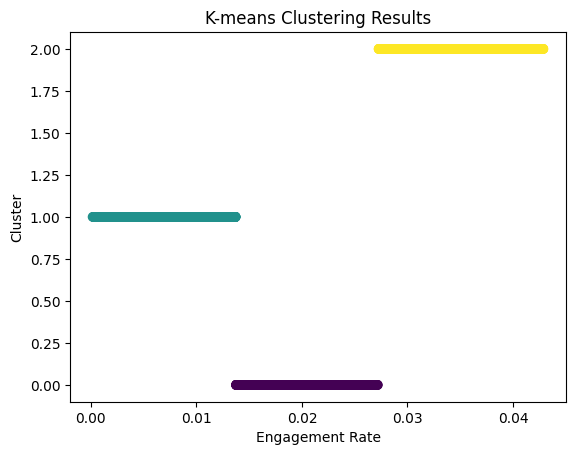

In [ ]:
# Create a scatter plot
plt.scatter(df['engagement_rate'],df['class_id'],c=df['class_id'])

# Set labels and title
plt.xlabel('Engagement Rate')
plt.ylabel('Cluster')
plt.title('K-means Clustering Results')

# Show the plot
plt.show()

From this, we can see that:


*   Cluster 1 is the lower engagement rates
*   Cluster 0 is the medium engagement rates
*   Cluster 2 is the higher engagement rates

In [ ]:
# Labelling the classes manually
df['class_label'] = df['class_id'].apply(lambda x: 'low' if x==1 else ('medium' if x== 0 else 'high'))

In [ ]:
df['class_label'].value_counts()

class_label
low       1836
medium    1454
high       996
Name: count, dtype: int64

# Split training and test data

In [ ]:
# Separate the features and the target variable
X = data  # Features
y = df['class_id']  # Target variable

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y,test_size = 0.20, random_state = 42)

# Train model with RandomForestClassifier

## Training model

In [ ]:
def train_predict_RF(x_train,y_train,x_test,y_test):
  # Create and fit the classifier
  clf = RandomForestClassifier(random_state = 42)
  clf.fit(x_train, y_train)

  # Predict
  y_pred = clf.predict(x_test)

  # Calculate accuracy on training set
  train_accuracy_rf = clf.score(x_train, y_train)

  # Calculate accuracy on the testing set
  test_accuracy_rf = accuracy_score(y_pred, y_test)

  # Generate classification report
  report_rf = classification_report(y_test, y_pred)

  print("Training Accuracy:", train_accuracy_rf)
  print("Testing Accuracy:", test_accuracy_rf)
  print("Classification Report:\n", report_rf)

In [ ]:
train_predict_RF(x_train,y_train,x_test,y_test)

Training Accuracy: 0.9924154025670945
Testing Accuracy: 0.4160839160839161
Classification Report:
               precision    recall  f1-score   support

           0       0.36      0.23      0.28       306
           1       0.44      0.76      0.56       369
           2       0.19      0.03      0.06       183

    accuracy                           0.42       858
   macro avg       0.33      0.34      0.30       858
weighted avg       0.36      0.42      0.35       858



## Oversample data

In [ ]:
# Apply SMOTE to oversample the minority classes
smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(x_train,y_train)

# Verify the balanced class distribution
unique_classes, class_counts = np.unique(y_resampled, return_counts=True)
for cls, count in zip(unique_classes, class_counts):
    print(f"Class: {cls}, Count: {count}")


Class: 0, Count: 1467
Class: 1, Count: 1467
Class: 2, Count: 1467


In [ ]:
train_predict_RF(x_resampled,y_resampled,x_test,y_test)

Training Accuracy: 0.9940922517609634
Testing Accuracy: 0.4114219114219114
Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.33      0.35       306
           1       0.48      0.59      0.53       369
           2       0.25      0.19      0.22       183

    accuracy                           0.41       858
   macro avg       0.37      0.37      0.37       858
weighted avg       0.39      0.41      0.40       858



Result is overfitting, try hyperparameter tuning.

In [ ]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a RandomForestClassifier instance
rf_classifier = RandomForestClassifier(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy',n_jobs=-1)
grid_search.fit(x_resampled, y_resampled)

# Print the best parameters found
print("Best Parameters: ", grid_search.best_params_)


Best Parameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}


In [ ]:
#best_params = grid_search.best_params_
best_params = {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
# Create and fit the classifier
rf_clf = RandomForestClassifier(random_state=42,
                                n_estimators=best_params['n_estimators'],
                                max_depth=best_params['max_depth'],
                                min_samples_split=best_params['min_samples_split'],
                                min_samples_leaf=best_params['min_samples_leaf']
                                )
rf_clf.fit(x_resampled, y_resampled)

# Predict
y_pred = rf_clf.predict(x_test)

# Calculate accuracy on training set
train_accuracy_rf1 = rf_clf.score(x_resampled, y_resampled)

# Calculate accuracy on the testing set
test_accuracy_rf1 = accuracy_score(y_pred, y_test)

# Generate classification report
report_rf1 = classification_report(y_test, y_pred)

print("Training Accuracy:", train_accuracy_rf1)
print("Testing Accuracy:", test_accuracy_rf1)
print("Classification Report:\n", report_rf1)

Training Accuracy: 0.9940922517609634
Testing Accuracy: 0.4114219114219114
Classification Report:
               precision    recall  f1-score   support

           0       0.36      0.25      0.30       306
           1       0.48      0.67      0.56       369
           2       0.23      0.16      0.19       183

    accuracy                           0.41       858
   macro avg       0.36      0.36      0.35       858
weighted avg       0.38      0.41      0.39       858



* Class 0 has low recall
* Class 2 has low precision and recall
* Model is heavily overfitting

## Adjust class weights

As observed, we still have data imbalance issues, which we will attempt to fix it with adjusting class weights.

In [ ]:
from sklearn.utils import compute_class_weight

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced',
                                     classes = np.unique(y_train),
                                     y = y_train)

# Convert class weights to dictionary format
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print(class_weights_dict)

{0: 0.9953542392566783, 1: 0.7789138832083617, 2: 1.4054940549405495}


In [ ]:
# Create and fit the classifier with class weights
rf_clf_cw = RandomForestClassifier(class_weight=class_weights_dict, random_state=42,
                                   n_estimators=best_params['n_estimators'],
                                   max_depth=best_params['max_depth'],
                                   min_samples_split=best_params['min_samples_split'],
                                   min_samples_leaf=best_params['min_samples_leaf'])
rf_clf_cw.fit(x_train, y_train)

# Predict
y_pred_cw = rf_clf_cw.predict(x_test)

# Calculate accuracy on training set
train_accuracy_rf_cw = rf_clf_cw.score(x_train, y_train)

# Calculate accuracy on the testing set
test_accuracy_rf_cw = accuracy_score(y_pred_cw, y_test)

# Generate classification report
report_rf_cw = classification_report(y_test, y_pred_cw)

print("Training Accuracy:", train_accuracy_rf_cw)
print("Testing Accuracy:", test_accuracy_rf_cw)
print("Classification Report:\n", report_rf_cw)

Training Accuracy: 0.9924154025670945
Testing Accuracy: 0.4417249417249417
Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.19      0.26       306
           1       0.45      0.84      0.59       369
           2       0.33      0.05      0.09       183

    accuracy                           0.44       858
   macro avg       0.40      0.36      0.31       858
weighted avg       0.42      0.44      0.37       858



* Still overfitting
* Better precision overall
* Extreme low recall in class 0 and worse, in 2


# Train model with Logistic Regression

Normalize and oversample data

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply oversampling to handle class imbalance
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_scaled, y_train)

## Train the logistic regression model

In [ ]:
# Create logistic regression model
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

# Fit the model on the resampled training data
logreg.fit(X_train_resampled, y_train_resampled)

c:\Users\Khanh Nguyen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, multi_class='multinomial')

## Predict and evaluate the model

In [ ]:
def predict_evaluate_logit(model):
  # Evaluate the model on the normalized testing embeddings
  y_pred = model.predict(X_test_scaled)

  # Calculate the probabilities for each class using predict_proba
  y_pred_proba = model.predict_proba(X_test_scaled)


  # Initialize empty lists to store the fpr, tpr, and roc_auc for each class
  fpr_list = []
  tpr_list = []
  roc_auc_list = []

  # Calculate the ROC curve and ROC-AUC score for each class
  for class_idx in range(len(model.classes_)):
      y_true_binary = np.where(y_test == model.classes_[class_idx], 1, 0)
      fpr, tpr, _ = roc_curve(y_true_binary, y_pred_proba[:, class_idx])
      roc_auc = roc_auc_score(y_true_binary, y_pred_proba[:, class_idx])

      fpr_list.append(fpr)
      tpr_list.append(tpr)
      roc_auc_list.append(roc_auc)

  # Plot the ROC curves for each class
  plt.figure()
  for class_idx in range(len(model.classes_)):
      plt.plot(fpr_list[class_idx], tpr_list[class_idx], label='ROC curve (area = %0.2f) for class %d'
              % (roc_auc_list[class_idx], class_idx))
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.legend(loc="lower right")
  plt.show()

  # Generate the classification report
  report = classification_report(y_test, y_pred)
  print("Classification Report:\n", report)
  return


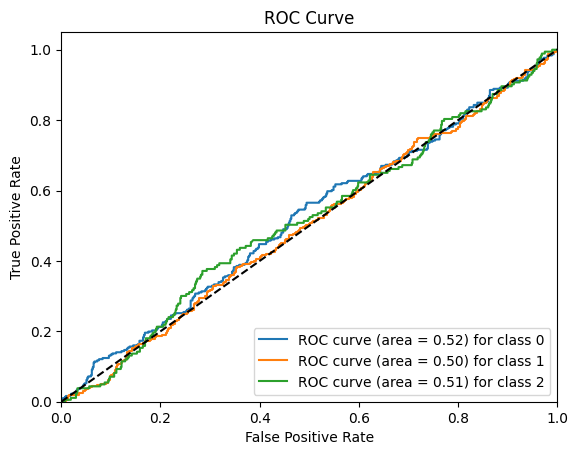

Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.33      0.35       306
           1       0.44      0.44      0.44       369
           2       0.24      0.30      0.26       183

    accuracy                           0.37       858
   macro avg       0.35      0.35      0.35       858
weighted avg       0.38      0.37      0.37       858



In [ ]:
# Evaluate the model on the normalized testing embeddings
y_pred_logreg = logreg.predict(X_test_scaled)

# Calculate the probabilities for each class using predict_proba
y_pred_proba = logreg.predict_proba(X_test_scaled)


# Initialize empty lists to store the fpr, tpr, and roc_auc for each class
fpr_list = []
tpr_list = []
roc_auc_list = []

# Calculate the ROC curve and ROC-AUC score for each class
for class_idx in range(len(logreg.classes_)):
    y_true_binary = np.where(y_test == logreg.classes_[class_idx], 1, 0)
    fpr, tpr, _ = roc_curve(y_true_binary, y_pred_proba[:, class_idx])
    roc_auc = roc_auc_score(y_true_binary, y_pred_proba[:, class_idx])

    fpr_list.append(fpr)
    tpr_list.append(tpr)
    roc_auc_list.append(roc_auc)

# Plot the ROC curves for each class
plt.figure()
for class_idx in range(len(logreg.classes_)):
    plt.plot(fpr_list[class_idx], tpr_list[class_idx], label='ROC curve (area = %0.2f) for class %d'
             % (roc_auc_list[class_idx], class_idx))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Generate the classification report
report = classification_report(y_test, y_pred_logreg)
print("Classification Report:\n", report)

* Logistic regression performs not well on the data
* In class 2, it is even worse than random guessing

## Hyper-tune parameters

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score, precision_recall_fscore_support

# Define hyperparameters to tune
param_grid = {
    'C': [0.00001, 0.01, 0.1, 1, 10],
    'class_weight': [None, 'balanced'],
    'max_iter': [200,500,1000],
}

# Create logistic regression model
logreg = LogisticRegression(multi_class='multinomial')

# Define scoring metrics
scoring = {
    'AUC-ROC': make_scorer(roc_auc_score, average='weighted'),
    'Precision': 'precision_weighted',
    'Recall': 'recall_weighted',
    'F1-Score': 'f1_weighted'
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, scoring=scoring, refit='AUC-ROC', cv=3)
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_model = grid_search.best_estimator_


c:\Users\Khanh Nguyen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:842: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Khanh Nguyen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
  File "c:\Users\Khanh Nguyen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "c:\Users\Khanh Nguyen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "c:\Users\Khanh Nguyen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py", line 619, in roc_auc_score
    raise ValueError

In [ ]:
print(best_model)

LogisticRegression(C=1e-05, max_iter=200, multi_class='multinomial')


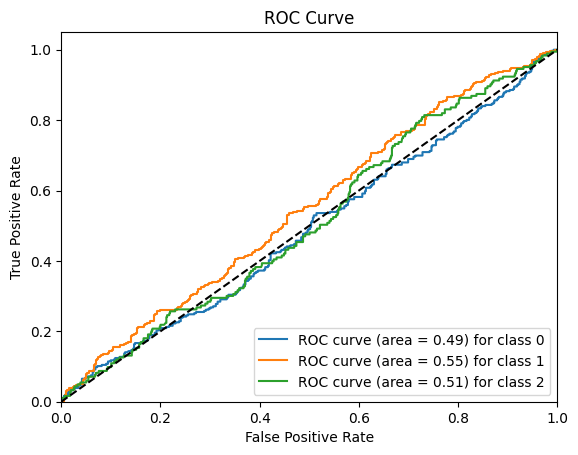

Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.17      0.23       306
           1       0.46      0.48      0.47       369
           2       0.21      0.35      0.26       183

    accuracy                           0.34       858
   macro avg       0.33      0.33      0.32       858
weighted avg       0.36      0.34      0.34       858



In [ ]:
predict_evaluate_logit(best_model)

Small improvement, but still not good enough to conclude that this is a good model.

## Save model

In [ ]:
import pickle
# Save the logreg model as a pickle file
pickle.dump(logreg, open("data/LogReg.pkl", "wb"))